In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

from trajectory import run_simulation_trajectory
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
n = 10000 # Starting plankton population size.
iters = 30 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, False)

In [4]:
x = []
y = []
y0 = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    y0.append(plankton_dict[id]['y0'])

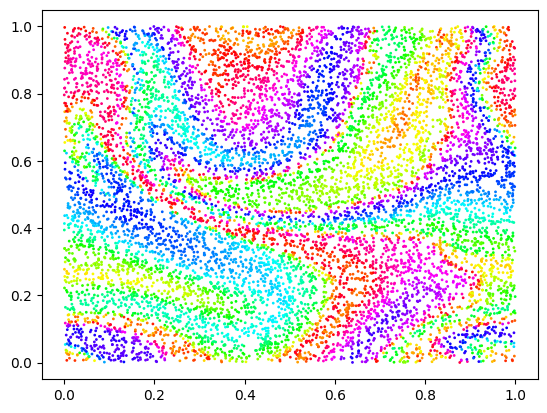

In [5]:
plt.scatter(x, y, c=y0, s=1, cmap=colour_map)
plt.show()

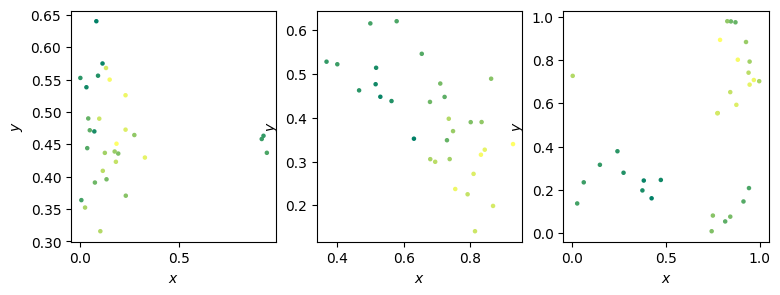

In [6]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([0,50,100]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

## Simulating with reproduction

In [47]:
n = 20000 # Starting plankton population size.
iters = 50 # Time steps.
L_max = 1 # Size of square domain.
colour_map = "hsv"

plankton_dict = run_simulation_trajectory(n, iters, L_max, True)

In [48]:
x = []
y = []
y0 = []
t_final = []
for id in plankton_dict:
    x.append(plankton_dict[id]['x'][-1])
    y.append(plankton_dict[id]['y'][-1])
    t_final.append(plankton_dict[id]['t'][-1])
    y0.append(plankton_dict[id]['y0'])

In [49]:
final_idx = np.where(t_final==np.max(t_final))[0]

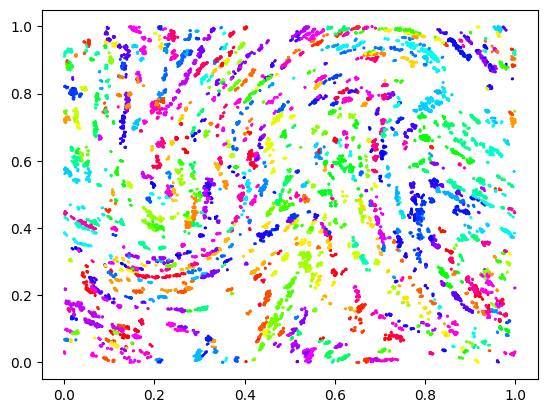

In [50]:
plt.scatter(np.array(x)[final_idx], np.array(y)[final_idx], c=np.array(y0)[final_idx], s=1, cmap=colour_map)
plt.show()

In [51]:
traj_len = []
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['x']))
long_traj = np.where(np.array(traj_len)>=10)[0]
long_traj

array([   282,    894,   1735,   2291,   3056,   3336,   3432,   3913,
         4041,   4167,   4429,   4628,   5262,   6629,   7226,   7421,
         7616,   7939,  10055,  10505,  12662,  12843,  13010,  13163,
        13919,  14940,  15033,  15114,  16618,  16838,  16946,  17042,
        17300,  17617,  17834,  19573,  19733,  20055,  20265,  21058,
        21619,  21773,  22344,  22751,  23426,  23470,  23548,  23655,
        23898,  24927,  25419,  25677,  25860,  26965,  28170,  28284,
        28834,  29140,  29290,  29348,  29438,  30213,  30475,  32698,
        32824,  33232,  33699,  33777,  34659,  35132,  35508,  36470,
        36793,  36862,  36935,  37382,  37847,  38886,  38888,  39520,
        39547,  39632,  39891,  40117,  42827,  42979,  43021,  43043,
        44022,  44895,  45098,  45733,  46818,  47581,  48977,  49337,
        49436,  49481,  49738,  49806,  50064,  50206,  50562,  51414,
        51997,  52080,  52643,  53132,  53274,  54683,  54698,  54807,
      

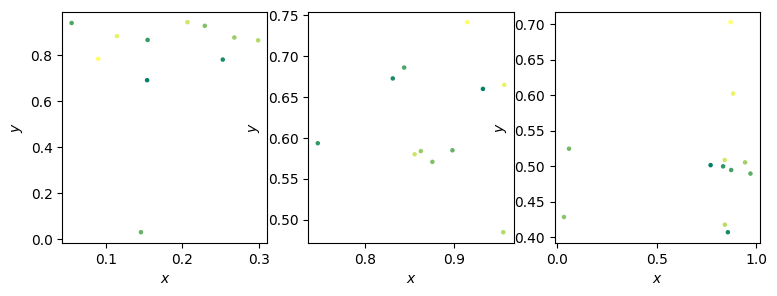

In [40]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

for i,id in enumerate([408,51828,146618]):
    ax.flatten()[i].set_xlabel('$x$')
    ax.flatten()[i].set_ylabel('$y$')
    ax.flatten()[i].scatter(plankton_dict[id]['x'], plankton_dict[id]['y'], 
                            c=plankton_dict[id]['t'], cmap='summer', s=5)

## Decorrelation time of Lagrange velocity

In [53]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]
    
def get_vel_autocorr(id):
    x = plankton_dict[id]['x']
    y = plankton_dict[id]['y']
    
    # Calculate velocity in x direction
    dx = np.diff(x) / 1  # assuming dt is 1
    
    # Calculate velocity in y direction
    dy = np.diff(y) / 1  # assuming dt is 1
    
    # Combine velocities into a single array
    velocity = np.sqrt(dx**2 + dy**2)
    
    # Calculate the autocorrelation function (ACF)

    
    autocorr_velocity = autocorr(velocity)
    lags = np.arange(0, len(velocity))
    return autocorr_velocity, lags

In [54]:
# Define an exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)
def fit_exp(lags, autocorr_velocity):
    # Fit the exponential function to the data
    popt, pcov = curve_fit(exponential_func, lags, autocorr_velocity)
    
    # Extract the parameters
    a_fit, b_fit = popt
    return a_fit, b_fit

In [55]:
decorr_time = []
for id in long_traj:
    autocorr_velocity, lags = get_vel_autocorr(id)
    a_fit, b_fit = fit_exp(lags, autocorr_velocity)
    
    # Print the fitted parameters
    #print("a:", a_fit)
    #print("b:", b_fit)
    decorr_time.append(-1/b_fit)
    #print(-1/b_fit)
print("Mean decorrelation time", np.mean(decorr_time))
print("Variance decorrelation time", np.var(decorr_time))

Mean decorrelation time 3.3172787256640923
Variance decorrelation time 3.7371599173717907


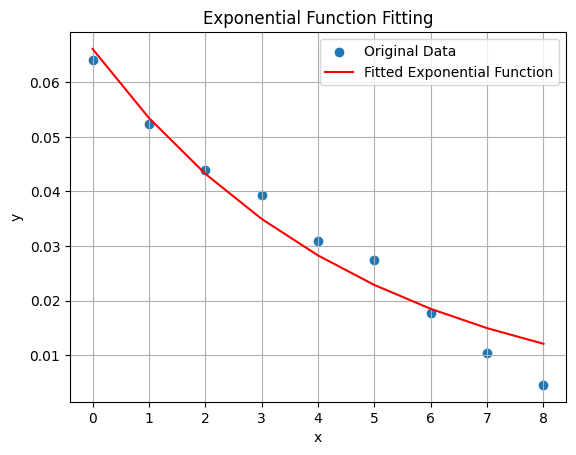

In [56]:
# Plot the original data and the fitted exponential function
plt.scatter(lags, autocorr_velocity, label='Original Data')
plt.plot(lags, exponential_func(lags, a_fit, b_fit), color='red', label='Fitted Exponential Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exponential Function Fitting')
plt.legend()
plt.grid(True)
plt.show()

## extract training data

In [57]:
len(list(plankton_dict.keys()))

513481

In [58]:
min_len = 4
traj_len = []

plankton_ids = list(plankton_dict.keys())
for id in plankton_dict:
    traj_len.append(len(plankton_dict[id]['t']))

# plankton ids with min trajectory length
plankton_min = np.where(np.array(traj_len)>=min_len)[0]

In [59]:
def get_coord(id, t):
    x = np.array(plankton_dict[id]['x'])[np.array(plankton_dict[id]['t'])==t]
    y = np.array(plankton_dict[id]['y'])[np.array(plankton_dict[id]['t'])==t]
    return [x,y]

In [60]:
min_len = 4
training_data = []
count = 0
count_total = 0
with open('training_data2.npy', 'wb') as f:
    for i,id1 in enumerate(plankton_min):
        for id2 in plankton_min[i+1:]:
            traj_intersec = set(plankton_dict[id1]['t']).intersection(set(plankton_dict[id2]['t']))
            if (len(traj_intersec) >= min_len):
                #print(id1,id2)
                #print(traj_times[id1], traj_times[id2], traj_intersec)
                traj_intersec = list(traj_intersec)[:min_len] #cutting longer intersections
                t1 = traj_intersec[0] 
                t2 = traj_intersec[-1]
                a1 = get_coord(id1, t1)
                a2 = get_coord(id1, t2)
                b1 = get_coord(id2, t1)
                b2 = get_coord(id2, t2)
                training_data.append(np.array((a1,b1,a2,b2)).squeeze())
                count+=1
                count_total += 1
                if count == 3000000: # save in batches that don't kill memory
                    np.save(f, training_data)
                    training_data = []
                    count = 0
                    if count_total==90000000:
                        break
    np.save(f, training_data) # save remaining samples

In [61]:
count_total

109924044

In [62]:
#data = []
with open('training_data2.npy', 'rb') as f:
    while True:
        try:
            # Load the next array and append it to the list
            
            loaded_array = np.load(f)
            #data.append(loaded_array)
            print('load', loaded_array.shape)
        except EOFError:
            # End of file reached
            break

load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (3000000, 4, 2)
load (1924044, 4, 2)
